In this notebook, we will implement a Convoulutional Neural Network (CNN) using pytorch for CIFAR-10 Classification.

Expectations: Please provide solutions to the questions in the cells at the end of the notebook.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
#from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

We will be using [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) datasets which is sub-dataset of CIFAR-100 Dataset. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. <br>

Following are the classes in the dataset along with some random samples.

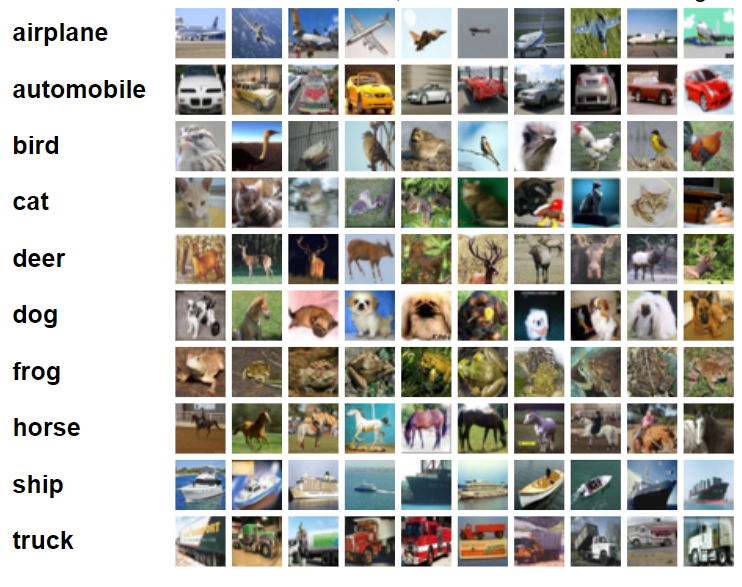

We will use pytorch datasets to fetch the CIFAR-10 dataset as it provides a handy way to get and use the dataset. More information about pytorch datasets [here](https://pytorch.org/vision/stable/datasets.html).

In [2]:
batch_sz=256 # this is batch size i.e. the number of rows in a batch of data

train_dataset = CIFAR10(root='./datasets', train=True, download=True, transform = transforms.ToTensor())
test_dataset = CIFAR10(root='./datasets', train=False, download=True, transform = transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size = batch_sz)
test_loader = DataLoader(test_dataset, batch_size = batch_sz)

100%|██████████| 170498071/170498071 [00:14<00:00, 11798422.03it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


## Transfer Learning

Transfer learning means taking the relevant parts of a pre-trained machine learning model and applying it to a new but similar problem. Transfer learning brings a range of benefits to the development process of machine learning models. The main benefits of transfer learning include the saving of resources and improved efficiency when training new models. It can also help with training models when only unlabelled datasets are available, as the bulk of the model will be pre-trained.

![Transfer Learning](https://topb0ts.wpenginepowered.com/wp-content/uploads/2019/12/cover_transfer_learning_1600px_web.jpg) [Source](https://www.topbots.com/transfer-learning-in-nlp/)

# Q1: define a 2 layer simple NN for cifar10 classificaiton

In [3]:
#Q1: define a 2 layer simple NN for cifar10 classificaiton
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x1 = F.relu(self.fc1(x))
        x = self.fc2(x1)
        return x, x1



In [4]:
#Q2: Define a CNN with 2 conv layer and 2 linear layers for cifar10 classificaiton
class Two_layer_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,3,1)
        self.conv2 = nn.Conv2d(64,128,3,1)
        self.fc1 = nn.Linear(128*3*3,512) # 10 class in CIFAR-10
        self.fc2 = nn.Linear(512,10) # 10 class in CIFAR-10

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x1 = F.max_pool2d(x, (2,2))

        x = self.conv2(x1)
        x = torch.relu(x)
        x2 = F.max_pool2d(x, (4,4))

        # classification head
        x3 = x2.view(-1, 128*3*3)

        x = self.fc1(x3)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.softmax(x, dim=1)

        return x, x1, x2, x3


# Q3: Train both networks for 10 epochs and compare their performances

In [5]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
print(device)

net1 = SimpleNN().to(device)

# setting hyper-parameters
lr = 1e-3
opt = optim.Adam(net1.parameters(), lr = lr)
# Scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=2, verbose=True)
Scheduler = optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.1)
num_epochs = 10

cuda:0


Epoch:  0 Loss:  1.960996608344876 Time:  9.640504598617554
Accuracy of the network on the 10000 test images: 34 %
Accuracy of the network on the 10000 train images: 35 %
Epoch:  1 Loss:  1.7409401967817424 Time:  10.34220290184021
Accuracy of the network on the 10000 test images: 39 %
Accuracy of the network on the 10000 train images: 40 %
Epoch:  2 Loss:  1.6554774441281144 Time:  8.760042428970337
Accuracy of the network on the 10000 test images: 42 %
Accuracy of the network on the 10000 train images: 43 %
Epoch:  3 Loss:  1.6033472698562 Time:  6.336313009262085
Accuracy of the network on the 10000 test images: 44 %
Accuracy of the network on the 10000 train images: 44 %
Epoch:  4 Loss:  1.5704604831277107 Time:  6.401251316070557
Accuracy of the network on the 10000 test images: 44 %
Accuracy of the network on the 10000 train images: 45 %
Epoch:  5 Loss:  1.5399126672014898 Time:  7.230175733566284
Accuracy of the network on the 10000 test images: 45 %
Accuracy of the network on t

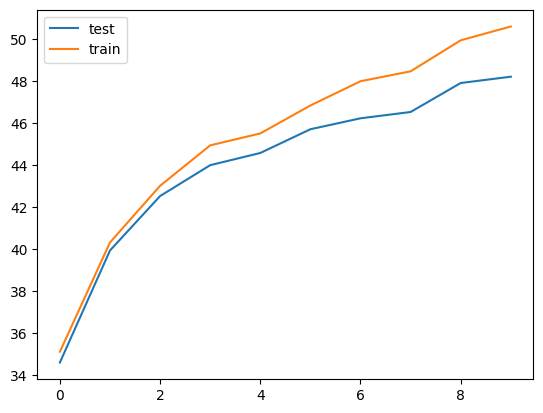

In [6]:
import time


ls = []
acc = []
acc_test = []
for i in range(num_epochs):
  total_loss = 0
  t=time.time()
  for batch in train_loader:

    X, Y = batch[0].to(device), batch[1].to(device)
    code = net1(X)[0]

    loss = F.cross_entropy(code, Y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss/len(train_loader))
  print("Epoch: ", i, "Loss: ", total_loss/len(train_loader), "Time: ", time.time()-t)

  with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
      X, Y = batch[0].to(device), batch[1].to(device)
      code = net1(X)[0]
      _, predicted = torch.max(code.data, 1)
      total += Y.size(0)
      correct += (predicted == Y).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    acc_test.append(correct/total*100)

    correct = 0
    total = 0
    for batch in train_loader:
      X, Y = batch[0].to(device), batch[1].to(device)
      code = net1(X)[0]
      _, predicted = torch.max(code.data, 1)
      total += Y.size(0)
      correct += (predicted == Y).sum().item()
    print('Accuracy of the network on the 10000 train images: %d %%' % (100 * correct / total))
    acc.append(correct/total*100)



# plt.plot(ls, label='train')
plt.plot(acc_test, label='test')
plt.plot(acc, label='train')
plt.legend()
plt.show()

In [7]:
# net1 = net1.to("cpu")

In [8]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

net2 = Two_layer_CNN().to(device)

# setting hyper-parameters
lr = 1e-3
opt = optim.Adam(net2.parameters(), lr = lr)
# Scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=2, verbose=True)
Scheduler = optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.01)
num_epochs = 10

Epoch:  0 Loss:  2.122752099012842 Time:  13.811583995819092
Accuracy of the network on the 10000 test images: 41 %
Accuracy of the network on the 10000 train images: 41 %
Epoch:  1 Loss:  2.009108995904728 Time:  9.82369327545166
Accuracy of the network on the 10000 test images: 49 %
Accuracy of the network on the 10000 train images: 49 %
Epoch:  2 Loss:  1.9537255770089674 Time:  9.777687549591064
Accuracy of the network on the 10000 test images: 50 %
Accuracy of the network on the 10000 train images: 51 %
Epoch:  3 Loss:  1.9152744077906316 Time:  9.876361846923828
Accuracy of the network on the 10000 test images: 56 %
Accuracy of the network on the 10000 train images: 57 %
Epoch:  4 Loss:  1.8821490425236371 Time:  9.882882356643677
Accuracy of the network on the 10000 test images: 58 %
Accuracy of the network on the 10000 train images: 59 %
Epoch:  5 Loss:  1.8603026362097994 Time:  9.840648651123047
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on

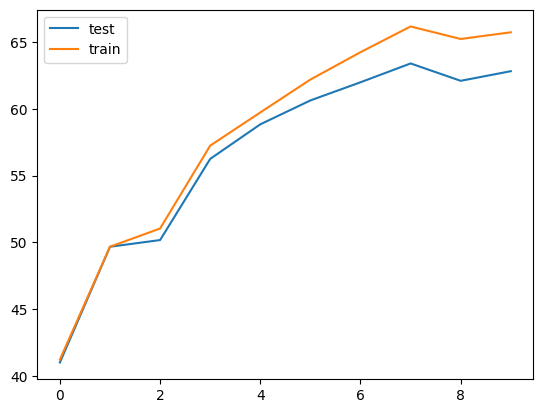

In [9]:
import time


ls = []
acc = []
acc_test = []
for i in range(num_epochs):
  total_loss = 0
  t=time.time()
  for batch in train_loader:

    X, Y = batch[0].to(device), batch[1].to(device)
    code = net2(X)[0]

    loss = F.cross_entropy(code, Y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss/len(train_loader))
  print("Epoch: ", i, "Loss: ", total_loss/len(train_loader), "Time: ", time.time()-t)

  with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
      X, Y = batch[0].to(device), batch[1].to(device)
      code = net2(X)[0]
      _, predicted = torch.max(code.data, 1)
      total += Y.size(0)
      correct += (predicted == Y).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    acc_test.append(correct/total*100)

    correct = 0
    total = 0
    for batch in train_loader:
      X, Y = batch[0].to(device), batch[1].to(device)
      code = net2(X)[0]
      _, predicted = torch.max(code.data, 1)
      total += Y.size(0)
      correct += (predicted == Y).sum().item()
    print('Accuracy of the network on the 10000 train images: %d %%' % (100 * correct / total))
    acc.append(correct/total*100)



# plt.plot(ls, label='train')
plt.plot(acc_test, label='test')
plt.plot(acc, label='train')
plt.legend()
plt.show()

In [10]:
# net2 = net2.to("cpu")

# Q4: Compare the accuarcay of both networks on the test set

In [11]:
def fetch_img(idx, loader):
    # fetching image for confusion matrix visualization
    bidx = 0
    while idx > batch_sz:
        idx -= batch_sz
        bidx += 1
    for i, batch in enumerate(loader):
        if i == bidx:
            return batch[0][idx], batch[1][idx]
    print("Index out of range")
    print("Max index is: ", i, "input index is ", idx)
    return None, None

def predict(model, loader):
    # forwards the model and returns the prediction
    # also returns the code from the last layer (float)
    pred = []
    code = []
    for batch in loader:
        X, Y = batch[0].to(device), batch[1].to(device)
        out = model(X)[0]
        pred.append(torch.argmax(out, dim=1))
        code.append(out)
    return torch.cat(pred), torch.cat(code)

def draw_confusion_matrix(model, loader):
    from sklearn.metrics import confusion_matrix
    # draws confusion matrix for the model
    # loader is the test loader
    # model is the trained model
    # The function will draw a confusion matrix for the model, with ground truth on the left and predicted on the top.
    # Some sample images will also be shown for each class.
    pred, code = predict(model, loader)
    Y = []
    for batch in loader:
        Y.append(batch[1])
    Y = torch.cat(Y)
    Y = Y.cpu().numpy()
    pred = pred.cpu().numpy()
    print(pred.shape, Y.shape)
    table = np.hstack((Y.reshape(-1,1), pred.reshape(-1,1)))
    cm = confusion_matrix(Y, pred)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.matshow(cm, cmap=plt.cm.Blues)
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    ax.set_ylabel('Ground Truth')
    ax.set_xlabel('Predicted')
    for i in range(10):
        for j in range(10):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

    # # drawing some sample images
    # fig, ax = plt.subplots(10, 10, figsize=(10,10))
    # for i in range(10):
    #     for j in range(10):
    #         idx = np.random.choice(np.where(table[:,0]==i)[0])
    #         img, _ = fetch_img(idx, loader)
    #         ax[i,j].imshow(img.permute(1,2,0))
    #         ax[i,j].set_xticks([])
    #         ax[i,j].set_yticks([])
    #         if j == 0:
    #             ax[i,j].set_ylabel('GT: '+str(i))
    #         if i == 9:
    #             ax[i,j].set_xlabel('Pred: '+str(j))

    plt.show()


    accu = np.sum(np.diag(cm))/np.sum(cm)
    precision = np.mean(np.diag(cm)/np.sum(cm, axis=0))
    recall = np.mean(np.diag(cm)/np.sum(cm, axis=1))
    f1 = 2*precision*recall/(precision+recall)
    print("Accuracy: ", accu)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 score: ", f1)
    return cm, accu, precision, recall, f1


(10000,) (10000,)


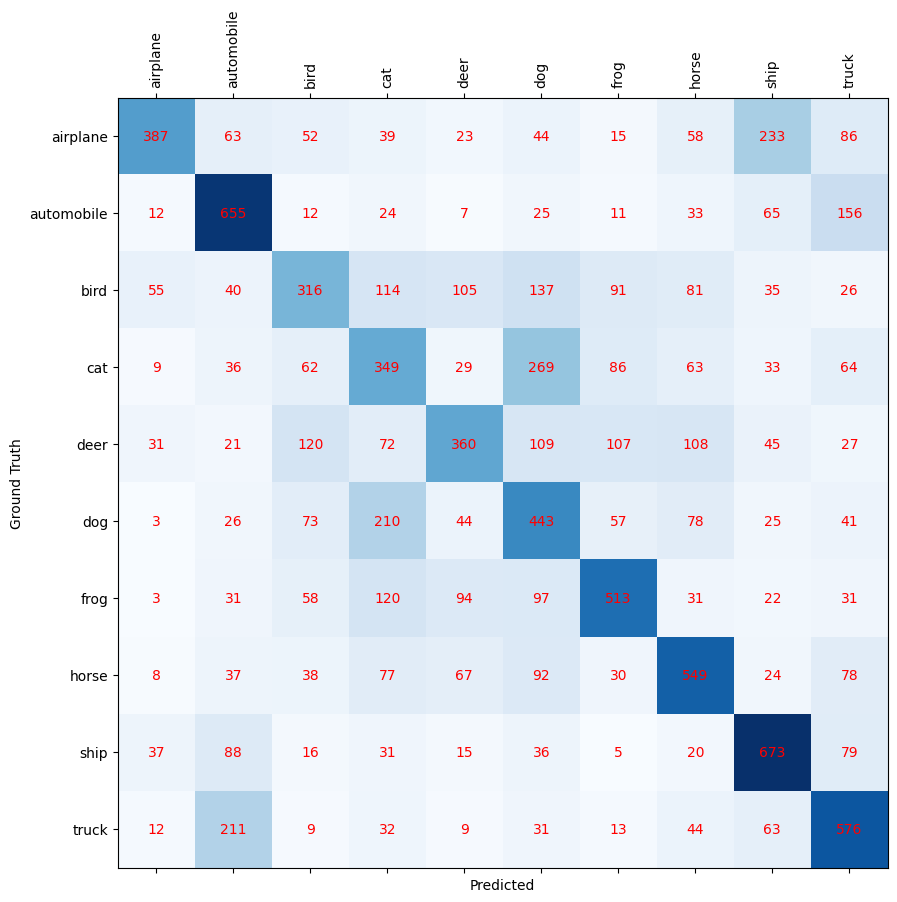

Accuracy:  0.4821
Precision:  0.4920837861640074
Recall:  0.4821
F1 score:  0.4870407343645295
(10000,) (10000,)


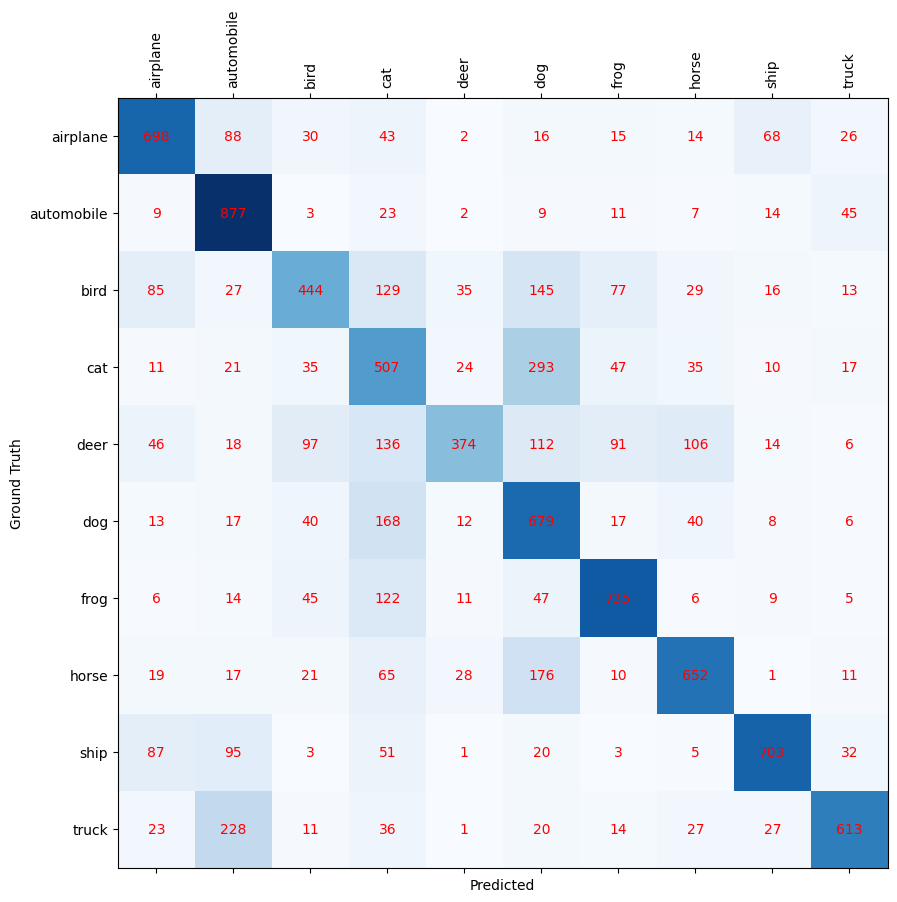

Accuracy:  0.6282
Precision:  0.6570191784035537
Recall:  0.6282
F1 score:  0.6422864750365775


In [12]:
_, acc1, _, _, f11 = draw_confusion_matrix(net1, test_loader)
_, acc2, _, _, f12 = draw_confusion_matrix(net2, test_loader)

In [13]:
# torch.cuda.empty_cache()

### Some comments on two models
Performaces of two models:
| | Simple NN | Simple CNN |
| --- | --- | --- |
| Train Loss | 1.4| 1.8|
| Test Acc. | 0.47 | 0.65|
| F1-score | 0.48 | 0.64|

The simple CNN model has better performance than the simple NN model. The simple CNN model has higher accuracy and F1-score than the simple NN model on test set. Compared to CNN model, the NN model have a tendency to overfitting, with lower training loss but lower test accuracy.
This is consistency with features of CNN, told in the lecture, that CNN is more compatible to handle large image dataset without overfitting, thanks to the shared weights design.

As for the classification result, the confusion matrix shows that two models both do well in distinguish animal and vehicle, but not so well in distinguish between different animals or vehicles. Mainly because subclasses are more similary.

# Q5: Fine-tune ResNet18 model trained on ImageNet for CIFAR10 dataset.

In [14]:
#finetuning here
# feature extactor ----> classifier
class ModifiedResNet(nn.Module):
    def __init__(self, original_model):
        super(ModifiedResNet, self).__init__()
        # copy the NN architecture from the original ResNet model
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        # add a new classifier
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        # obtain the feature representation
        representation = self.features(x)
        # forward
        output = self.classifier(representation.view(-1, 512))
        return output, representation

net3 = ModifiedResNet(models.resnet18(pretrained=True)).to(device)
#freezing the network (backbone)
for params in net3.features.parameters():
    # this only freezes the backbone
    params.requires_grad = False


# for name, params in net.named_parameters():
#   print(name, params.requires_grad)

# modify the forward function, output both the code and the feature map (codes, features)
# summary(net3, (3, 32, 32))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 314MB/s]


Epoch:  0 Loss:  1.8158536924391377 Time:  9.730982303619385
Accuracy of the network on the 10000 test images: 42 %
Accuracy of the network on the 10000 train images: 44 %
Epoch:  1 Loss:  1.6081075911619225 Time:  9.229064702987671
Accuracy of the network on the 10000 test images: 44 %
Accuracy of the network on the 10000 train images: 46 %
Epoch:  2 Loss:  1.567429431238953 Time:  9.54599380493164
Accuracy of the network on the 10000 test images: 45 %
Accuracy of the network on the 10000 train images: 46 %
Epoch:  3 Loss:  1.5472221544810705 Time:  9.416757583618164
Accuracy of the network on the 10000 test images: 45 %
Accuracy of the network on the 10000 train images: 47 %
Epoch:  4 Loss:  1.534867295197078 Time:  8.970051050186157
Accuracy of the network on the 10000 test images: 45 %
Accuracy of the network on the 10000 train images: 47 %


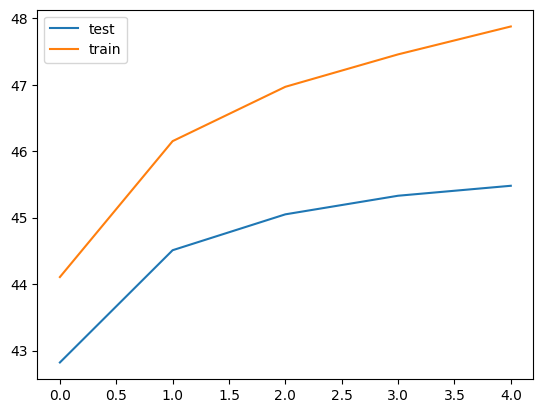

In [15]:
# training classifier
net3 = net3.to(device)

lr = 0.001
momentum = 0.5
num_epochs = 5

opt = torch.optim.Adam(net3.parameters(), lr=lr)


ls = []
acc = []
acc_test = []
for i in range(num_epochs):
  total_loss = 0
  t=time.time()
  for batch in train_loader:

    X, Y = batch[0].to(device), batch[1].to(device)
    code = net3(X)[0]

    loss = F.cross_entropy(code, Y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss/len(train_loader))
  print("Epoch: ", i, "Loss: ", total_loss/len(train_loader), "Time: ", time.time()-t)

  with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
      X, Y = batch[0].to(device), batch[1].to(device)
      code = net3(X)[0]
      _, predicted = torch.max(code.data, 1)
      total += Y.size(0)
      correct += (predicted == Y).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    acc_test.append(correct/total*100)

    correct = 0
    total = 0
    for batch in train_loader:
      X, Y = batch[0].to(device), batch[1].to(device)
      code = net3(X)[0]
      _, predicted = torch.max(code.data, 1)
      total += Y.size(0)
      correct += (predicted == Y).sum().item()
    print('Accuracy of the network on the 10000 train images: %d %%' % (100 * correct / total))
    acc.append(correct/total*100)



# plt.plot(ls, label='train')
plt.plot(acc_test, label='test')
plt.plot(acc, label='train')
plt.legend()
plt.show()

Epoch:  0 Loss:  0.8550915775858626 Time:  13.09272813796997
Accuracy of the network on the 10000 test images: 77 %
Accuracy of the network on the 10000 train images: 82 %
Epoch:  1 Loss:  0.5221461960855796 Time:  13.081041812896729
Accuracy of the network on the 10000 test images: 78 %
Accuracy of the network on the 10000 train images: 86 %
Epoch:  2 Loss:  0.37907005215481837 Time:  13.100646734237671
Accuracy of the network on the 10000 test images: 79 %
Accuracy of the network on the 10000 train images: 89 %
Epoch:  3 Loss:  0.3054782603772319 Time:  13.14721131324768
Accuracy of the network on the 10000 test images: 79 %
Accuracy of the network on the 10000 train images: 91 %
Epoch:  4 Loss:  0.24107702601016784 Time:  13.124613523483276
Accuracy of the network on the 10000 test images: 79 %
Accuracy of the network on the 10000 train images: 92 %
Epoch:  5 Loss:  0.1993459888486838 Time:  13.097594022750854
Accuracy of the network on the 10000 test images: 80 %
Accuracy of the ne

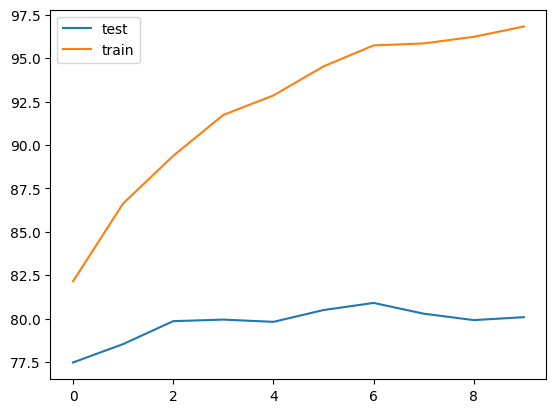

In [16]:
#unfreezing
for params in net3.features.parameters():
    params.requires_grad = True
# fine-tuning the whole network
lr = 0.001
momentum = 0.5
num_epochs = 10

opt = torch.optim.Adam(net3.parameters(), lr = lr)

ls = []
acc = []
acc_test = []
for i in range(num_epochs):
  total_loss = 0
  t=time.time()
  for batch in train_loader:

    X, Y = batch[0].to(device), batch[1].to(device)
    code = net3(X)[0]

    loss = F.cross_entropy(code, Y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss/len(train_loader))
  print("Epoch: ", i, "Loss: ", total_loss/len(train_loader), "Time: ", time.time()-t)

  with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
      X, Y = batch[0].to(device), batch[1].to(device)
      code = net3(X)[0]
      _, predicted = torch.max(code.data, 1)
      total += Y.size(0)
      correct += (predicted == Y).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    acc_test.append(correct/total*100)

    correct = 0
    total = 0
    for batch in train_loader:
      X, Y = batch[0].to(device), batch[1].to(device)
      code = net3(X)[0]
      _, predicted = torch.max(code.data, 1)
      total += Y.size(0)
      correct += (predicted == Y).sum().item()
    print('Accuracy of the network on the 10000 train images: %d %%' % (100 * correct / total))
    acc.append(correct/total*100)



# plt.plot(ls, label='train')
plt.plot(acc_test, label='test')
plt.plot(acc, label='train')
plt.legend()
plt.show()

(10000,) (10000,)


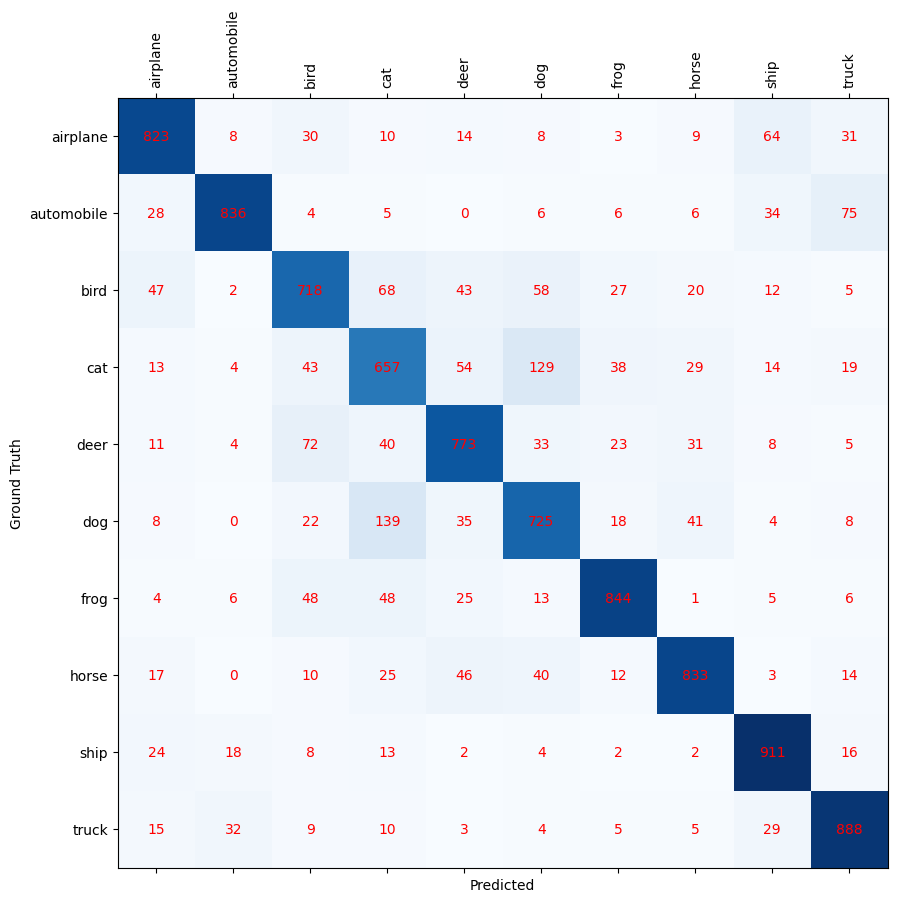

Accuracy:  0.8008
Precision:  0.801800864909317
Recall:  0.8008
F1 score:  0.8013001199218912


In [17]:
_, acc3, _, _, f13 = draw_confusion_matrix(net3, test_loader)

# Q6:Compare the accuarcay of simple CNN and ResNet18 model on the test set

I will compare the performance of two models using two criterion:
1. the accuracy of the model on the test set, including accuracy, precision, recall, and F1 score. A confusion matrix will be drawn to visualize the performance of the model.(And A correct/fail example will be given)
2. The visualizatio of representaiton space using t-SNE.

## Representation
For computational efficiency, here only use 10 first batch for visualization.

In [18]:
def t_SNE_vis(net, loader):
    from sklearn.manifold import TSNE
    # draws t-SNE visualization for the model
    representation = []
    lables = []
    for vis_idx, batch in enumerate(loader):
        X, Y = batch[0].to(device), batch[1].to(device)
        code = net(X)[-1].cpu().detach().numpy()
        Y = Y.cpu().detach().numpy()
        representation.append(code)
        lables.append(Y)
        if vis_idx>=9:
          break

    representation = np.vstack(representation)
    lables = np.hstack(lables)
    print(representation.shape, lables.shape) # debugging
    representation = TSNE(n_components=2).fit_transform(representation.reshape(representation.shape[0], -1))

    plt.figure(figsize=(10,10))
    for i in range(10):
        idx = np.where(lables==i)[0]
        plt.scatter(representation[idx,0], representation[idx,1], label=i)
    plt.legend()
    plt.show()


(2560, 512) (2560,)


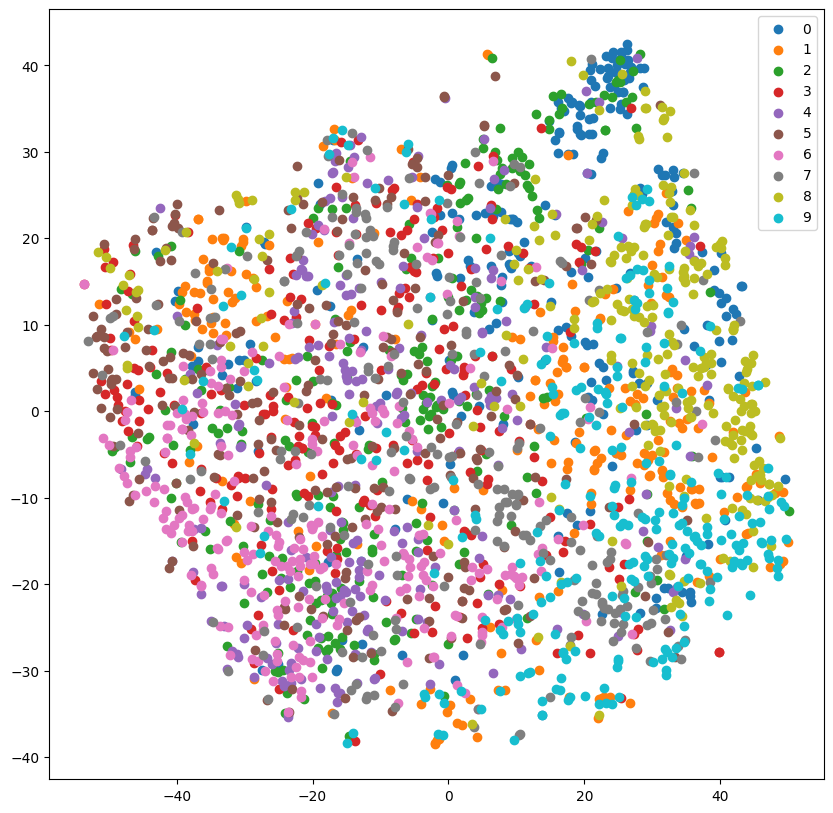

(2560, 1152) (2560,)


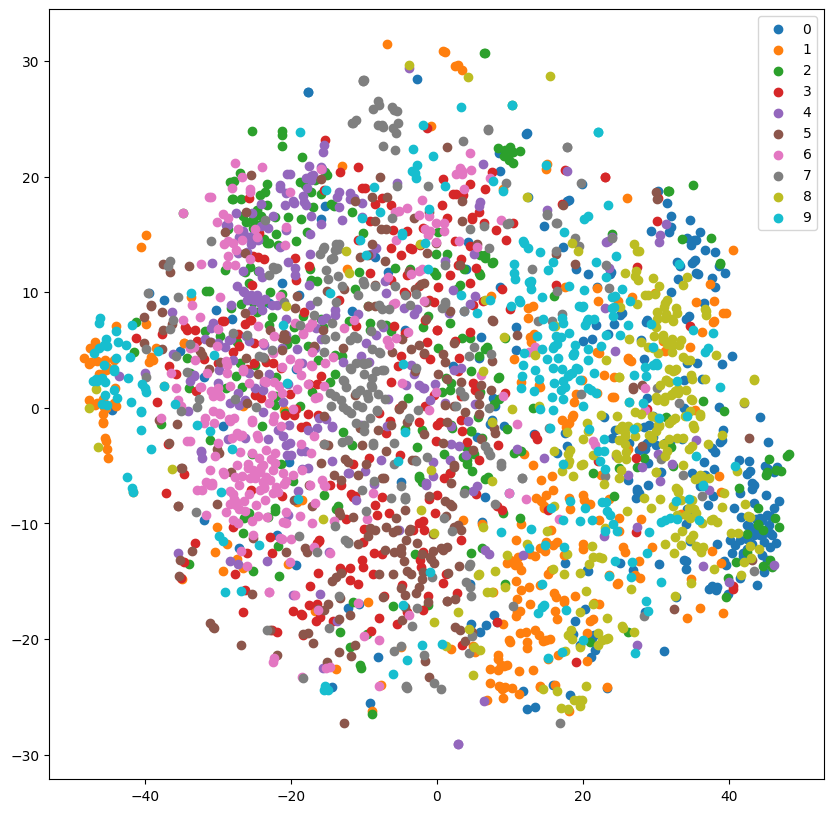

(2560, 512, 1, 1) (2560,)


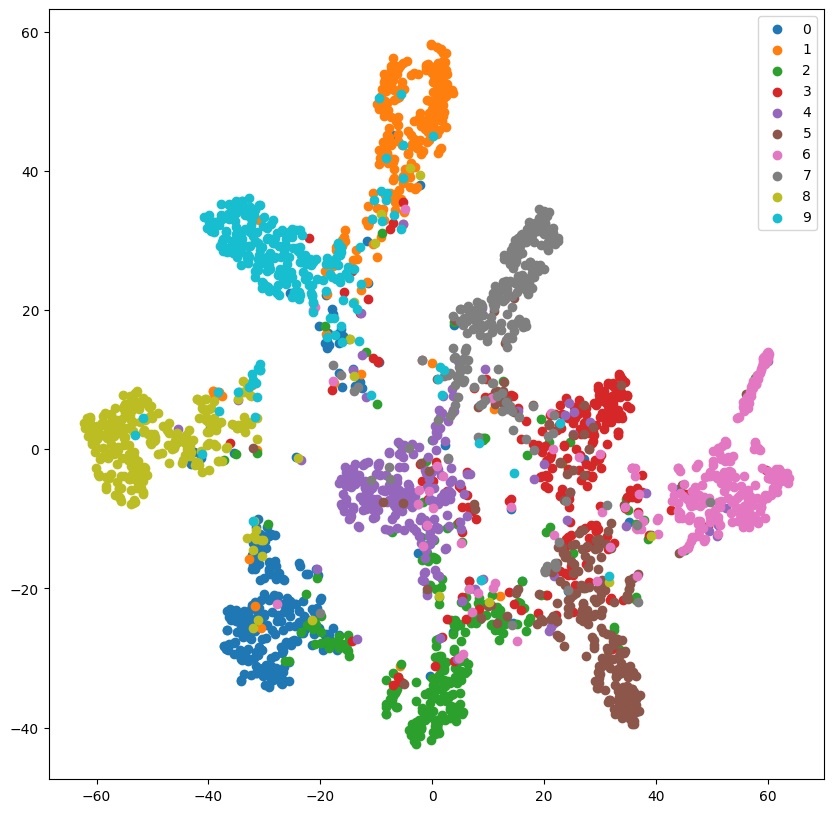

In [19]:
t_SNE_vis(net1, test_loader)
t_SNE_vis(net2, test_loader)
t_SNE_vis(net3, test_loader)

#### Above three figures are the representation (feature space) learned by three models, respectively.
I use t-SNE to reduce the dimension from 512 to 2. This is a method based on the density of data.
The top figure, the representation of simple NN, shows a rather ramdon distribution of data points. I cannot find any obvious cluster of classes in the figure.
The middle one, the representation of simple CNN, is better. Though still in a ramdon behavior, there is a tendency that data from the same class is grouped together. For example, group 6 (pink point) is centered on the left bottom of figure.
In the contrary, the representation learnt by ResNet18 clusters data points well. Nearly each class form a group, and stay away from overall average. Such good representation may imply that an accuracy of 70% is not because of the limitation of such backbone(ResNet), but because of the classification head. If we change a deeper head, for example a 3-layer MLP, I think the model will perform much better.


## Performance
Calculate the performance of fine-tuned model, the other two has been already calculated.

In [20]:
import pandas as pd
table = pd.DataFrame({'Simple NN':[acc1, f11], '2-layer CNN':[acc2, f12], 'ResNet18':[acc3, f13]}, index=['Accuracy', 'F1 score'])
table

,Simple NN,2-layer CNN,ResNet18
Accuracy,0.482100,0.628200,0.8008
F1 score,0.487041,0.642286,0.8013


Performaces of 3 models:
| | Simple NN | Simple CNN | fine-tuned RN |
| --- | --- | --- | --- |
| Train Loss | 1.4| 1.8| 0.68|
| Test Acc. | 0.47 | 0.63| 0.80 |
| F1-score | 0.48 | 0.64| 0.80 |

The Loss of fine-tuned ResNet18 is lower, and its accuracy on test set is also higher. This indicates this model is better fitted and have a better generalization ability, which can be expected from its learned representation.

However, the impovement of 7% accuracy is at the cost of enlarging the model size. This will result in more computational cost and higher requirement of GPU. This is somehow another kind of trade-off.